In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
import datetime
from pmdarima.model_selection import train_test_split

In [88]:
food_data = pd.read_json('data/food_data1.json')
for i in range(2, 12):
    filename = 'data/food_data' + str(i) + '.json'
    df = pd.read_json(filename)
    food_data = pd.concat([food_data, df], ignore_index=True)

healthcare_data = pd.read_json('data/healthcare_data1.json')
for i in range(2, 5):
    filename = 'data/healthcare_data' + str(i) + '.json'
    df = pd.read_json(filename)
    healthcare_data = pd.concat([healthcare_data, df], ignore_index=True)

major_purchases_data = pd.read_json('data/major_purchases_data1.json')
for i in range(2, 7):
    filename = 'data/major_purchases_data' + str(i) + '.json'
    df = pd.read_json(filename)
    major_purchases_data = pd.concat([major_purchases_data, df], ignore_index=True)

utility_data = pd.read_json('data/utility_data1.json')
for i in range(2, 8):
    filename = 'data/utility_data' + str(i) + '.json'
    df = pd.read_json(filename)
    utility_data = pd.concat([utility_data, df], ignore_index=True)

food_data.drop(columns=['series id'], inplace=True)
healthcare_data.drop(columns=['series id'], inplace=True)
major_purchases_data.drop(columns=['series id'], inplace=True)
utility_data.drop(columns=['series id'], inplace=True)

food_data = food_data.rename(columns={'value': 'CPI'})
healthcare_data = healthcare_data.rename(columns={'value': 'CPI'})
major_purchases_data = major_purchases_data.rename(columns={'value': 'CPI'})
utility_data = utility_data.rename(columns={'value': 'CPI'})

In [89]:
month_conversion = {'M01':'01', 'M02':'02', 'M03':'03', 'M04':'04', 'M05':'05', 'M06':'06', 'M07':'07', 'M08':'08',
                   'M09':'09', 'M10':'10', 'M11':'11', 'M12':'12'}

food_data['period'] = food_data['period'].replace(month_conversion)
healthcare_data['period'] = healthcare_data['period'].replace(month_conversion)
major_purchases_data['period'] = major_purchases_data['period'].replace(month_conversion)
utility_data['period'] = utility_data['period'].replace(month_conversion)

In [90]:
# create datetime objects for time series analysis
date_list = []
value = ''
for i in range(len(food_data['period'])):
    value = str(food_data['year'][i]) + '-' + str(food_data['period'][i]) + '-01'
    date_list.append(value)
food_data['date'] = date_list
food_data['date'] = pd.to_datetime(food_data['date'])

date_list.clear()
for i in range(len(healthcare_data['period'])):
    value = str(healthcare_data['year'][i]) + '-' + str(healthcare_data['period'][i]) + '-01'
    date_list.append(value)
healthcare_data['date'] = date_list
healthcare_data['date'] = pd.to_datetime(healthcare_data['date'])

date_list.clear()
for i in range(len(major_purchases_data['period'])):
    value = str(major_purchases_data['year'][i]) + '-' + str(major_purchases_data['period'][i]) + '-01'
    date_list.append(value)
major_purchases_data['date'] = date_list
major_purchases_data['date'] = pd.to_datetime(major_purchases_data['date'])

date_list.clear()
for i in range(len(utility_data['period'])):
    value = str(utility_data['year'][i]) + '-' + str(utility_data['period'][i]) + '-01'
    date_list.append(value)
utility_data['date'] = date_list
utility_data['date'] = pd.to_datetime(utility_data['date'])

In [96]:
food_data.head(15)

,period,CPI,year,date
0,12,314.459,2022,2022-12-01
1,11,313.467,2022,2022-11-01
2,10,312.860,2022,2022-10-01
3,09,310.678,2022,2022-09-01
4,08,308.550,2022,2022-08-01
5,07,306.278,2022,2022-07-01
6,06,302.967,2022,2022-06-01
7,05,300.081,2022,2022-05-01
8,04,296.915,2022,2022-04-01
9,03,294.064,2022,2022-03-01


In [100]:
result = food_data[food_data['period'] == '01']
result

,period,CPI,year,date
11,01,288.264,2022,2022-01-01
23,01,270.260,2021,2021-01-01
35,01,260.638,2020,2020-01-01
47,01,256.185,2019,2019-01-01
59,01,252.109,2018,2018-01-01
...,...,...,...,...
1271,01,266.079,2017,2017-01-01
1283,01,259.958,2016,2016-01-01
1295,01,253.037,2015,2015-01-01
1307,01,245.481,2014,2014-01-01


In [111]:
food_df = pd.DataFrame(columns=['month', 'average CPI', 'year', 'date'])
healthcare_df = pd.DataFrame(columns=['month', 'average CPI', 'year', 'date'])
major_purchases_df = pd.DataFrame(columns=['month', 'average CPI', 'year', 'date'])
utility_df = pd.DataFrame(columns=['month', 'average CPI', 'year', 'date'])

month_array = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
year_array = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
for month in month_array:
    df = food_data[food_data['period'] == month]
    for year in year_array:
        sub_df = df[df['year'] == year]
        CPI_avg = sub_df['CPI'].mean()
        
        # construct new dataframe with average CPIs and datetimes
        date = str(year) + '-' + str(month) + '-01'
        date = pd.to_datetime(date)
        food_df.loc[len(food_df)] = [month, CPI_avg, year, date]
        
for month in month_array:
    df = healthcare_data[healthcare_data['period'] == month]
    for year in year_array:
        sub_df = df[df['year'] == year]
        CPI_avg = sub_df['CPI'].mean()
        
        # construct new dataframe with average CPIs and datetimes
        date = str(year) + '-' + str(month) + '-01'
        date = pd.to_datetime(date)
        healthcare_df.loc[len(healthcare_df)] = [month, CPI_avg, year, date]

for month in month_array:
    df = major_purchases_data[major_purchases_data['period'] == month]
    for year in year_array:
        sub_df = df[df['year'] == year]
        CPI_avg = sub_df['CPI'].mean()
        
        # construct new dataframe with average CPIs and datetimes
        date = str(year) + '-' + str(month) + '-01'
        date = pd.to_datetime(date)
        major_purchases_df.loc[len(major_purchases_df)] = [month, CPI_avg, year, date]

for month in month_array:
    df = utility_data[utility_data['period'] == month]
    for year in year_array:
        sub_df = df[df['year'] == year]
        CPI_avg = sub_df['CPI'].mean()
        
        # construct new dataframe with average CPIs and datetimes
        date = str(year) + '-' + str(month) + '-01'
        date = pd.to_datetime(date)
        utility_df.loc[len(utility_df)] = [month, CPI_avg, year, date]

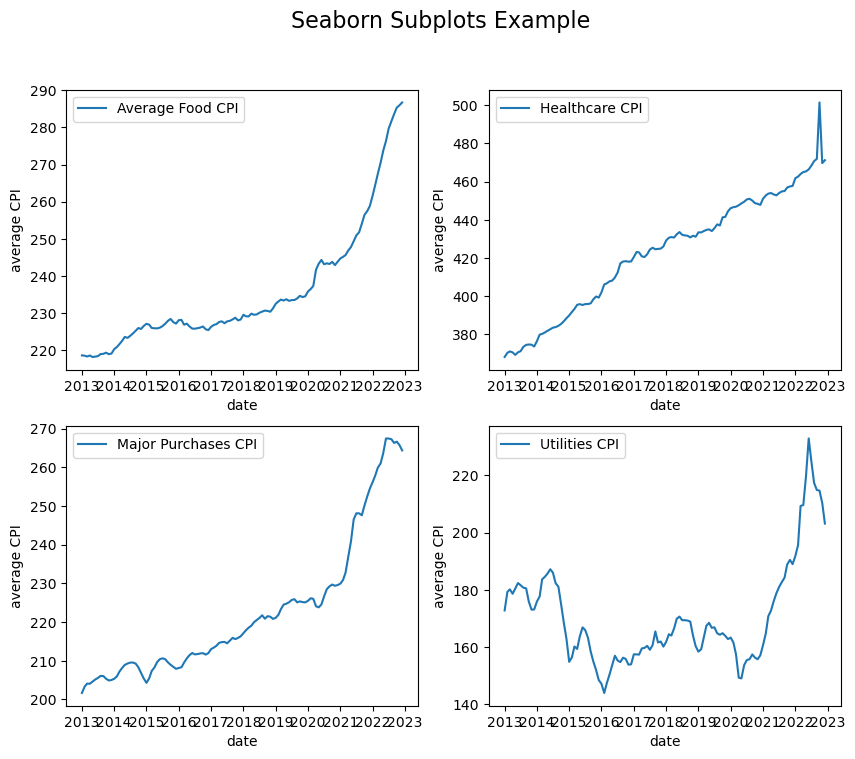

In [121]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.lineplot(x=food_df['date'], y=food_df['average CPI'], ax=axes[0, 0], label='Average Food CPI')
sns.lineplot(x=healthcare_df['date'], y=healthcare_df['average CPI'], ax=axes[0, 1], label='Healthcare CPI')
sns.lineplot(x=major_purchases_df['date'], y=major_purchases_df['average CPI'], ax=axes[1, 0], label='Major Purchases CPI')
sns.lineplot(x=utility_df['date'], y=utility_df['average CPI'], ax=axes[1, 1], label='Utilities CPI')

fig.suptitle('Seaborn Subplots Example', fontsize=16)

plt.show()